In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.makedirs("/content/asl_data/train", exist_ok=True)

In [4]:
!unzip "/content/drive/MyDrive/asl_alphabet_train.zip" -d "/content/asl_data/train"

Streaming output truncated to the last 5000 lines.
  inflating: /content/asl_data/train/asl_alphabet_train/B/B787.jpg  
  inflating: /content/asl_data/train/asl_alphabet_train/B/B785.jpg  
  inflating: /content/asl_data/train/asl_alphabet_train/B/B781.jpg  
  inflating: /content/asl_data/train/asl_alphabet_train/B/B78.jpg  
  inflating: /content/asl_data/train/asl_alphabet_train/B/B775.jpg  
  inflating: /content/asl_data/train/asl_alphabet_train/B/B774.jpg  
  inflating: /content/asl_data/train/asl_alphabet_train/B/B770.jpg  
  inflating: /content/asl_data/train/asl_alphabet_train/B/B77.jpg  
  inflating: /content/asl_data/train/asl_alphabet_train/B/B767.jpg  
  inflating: /content/asl_data/train/asl_alphabet_train/B/B765.jpg  
  inflating: /content/asl_data/train/asl_alphabet_train/B/B764.jpg  
  inflating: /content/asl_data/train/asl_alphabet_train/B/B763.jpg  
  inflating: /content/asl_data/train/asl_alphabet_train/B/B758.jpg  
  inflating: /content/asl_data/train/asl_alphabet_trai

In [5]:

import os
os.makedirs("/content/asl_data/test", exist_ok=True)

!unzip "/content/drive/MyDrive/asl_alphabet_test.zip" -d "/content/asl_data/test"


Archive:  /content/drive/MyDrive/asl_alphabet_test.zip
   creating: /content/asl_data/test/asl_alphabet_test/
  inflating: /content/asl_data/test/asl_alphabet_test/A_test.jpg  
  inflating: /content/asl_data/test/asl_alphabet_test/B_test.jpg  
  inflating: /content/asl_data/test/asl_alphabet_test/C_test.jpg  
  inflating: /content/asl_data/test/asl_alphabet_test/D_test.jpg  
  inflating: /content/asl_data/test/asl_alphabet_test/E_test.jpg  
  inflating: /content/asl_data/test/asl_alphabet_test/F_test.jpg  
  inflating: /content/asl_data/test/asl_alphabet_test/G_test.jpg  
  inflating: /content/asl_data/test/asl_alphabet_test/H_test.jpg  
  inflating: /content/asl_data/test/asl_alphabet_test/I_test.jpg  
  inflating: /content/asl_data/test/asl_alphabet_test/J_test.jpg  
  inflating: /content/asl_data/test/asl_alphabet_test/K_test.jpg  
  inflating: /content/asl_data/test/asl_alphabet_test/L_test.jpg  
  inflating: /content/asl_data/test/asl_alphabet_test/M_test.jpg  
  inflating: /conte

# ASL Sign Language Recognition (CNN)

This project applies deep learning to the task of recognizing hand signs from the American Sign Language (ASL) alphabet. A convolutional neural network is trained on a dataset of labeled hand gesture images across 29 classes (A–Z, space, delete, nothing). The model is evaluated using validation accuracy and prediction on unseen test images.

In [26]:
import pandas as pd
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report

In [17]:
import shutil
for cls in ["space", "delete", "nothing"]:
    path = f"/content/asl_data/train/{cls}"
    try:
        shutil.rmtree(path)
        print(f"Removed: {cls}")
    except FileNotFoundError:
        print(f"{cls} not found — already removed.")

space not found — already removed.
delete not found — already removed.
nothing not found — already removed.


## Data Loading & Preprocessing

The dataset is organized in folders where each folder name represents a class. Images are resized to 64x64 pixels and normalized. Data is split into 80% training and 20% validation.


In [18]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    "/content/asl_data/train/asl_alphabet_train",
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    "/content/asl_data/train/asl_alphabet_train",
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

class_labels = list(train_generator.class_indices.keys())

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


## Class Distribution

Visualizing how many images per class exist in the training set.

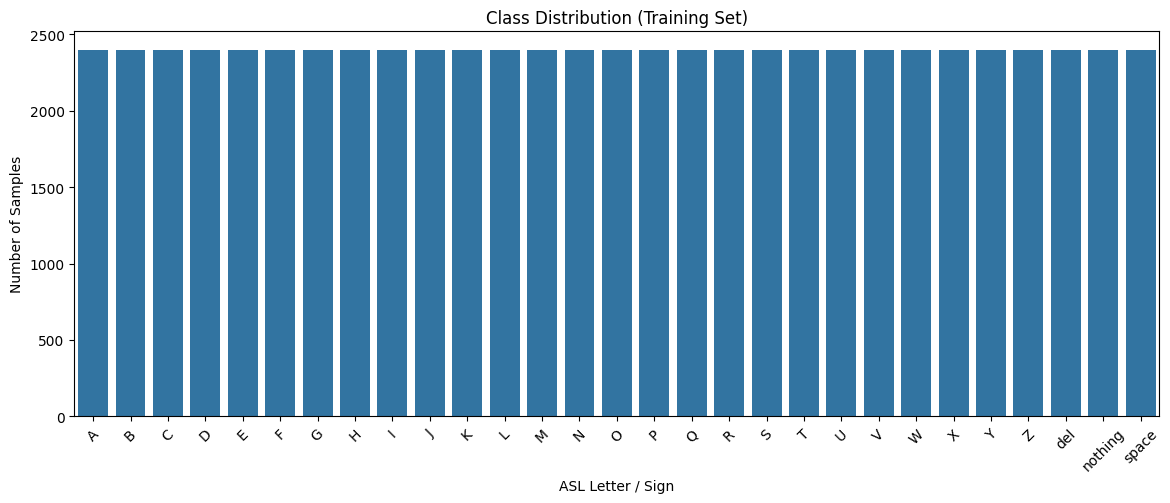

In [19]:
label_counts = pd.Series(train_generator.classes).value_counts().sort_index()
label_names = [k for k, v in sorted(train_generator.class_indices.items(), key=lambda item: item[1])]

plt.figure(figsize=(14, 5))
sns.barplot(x=label_names, y=label_counts.values)
plt.title("Class Distribution (Training Set)")
plt.ylabel("Number of Samples")
plt.xlabel("ASL Letter / Sign")
plt.xticks(rotation=45)
plt.show()

## CNN Architecture

The CNN has 3 convolutional layers with max pooling, followed by dense layers. Softmax is used for 29-class classification.

In [8]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_labels), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 686,941 (2.62 MB)

 Trainable params: 686,941 (2.62 MB)

 Non-trainable params: 0 (0.00 B)

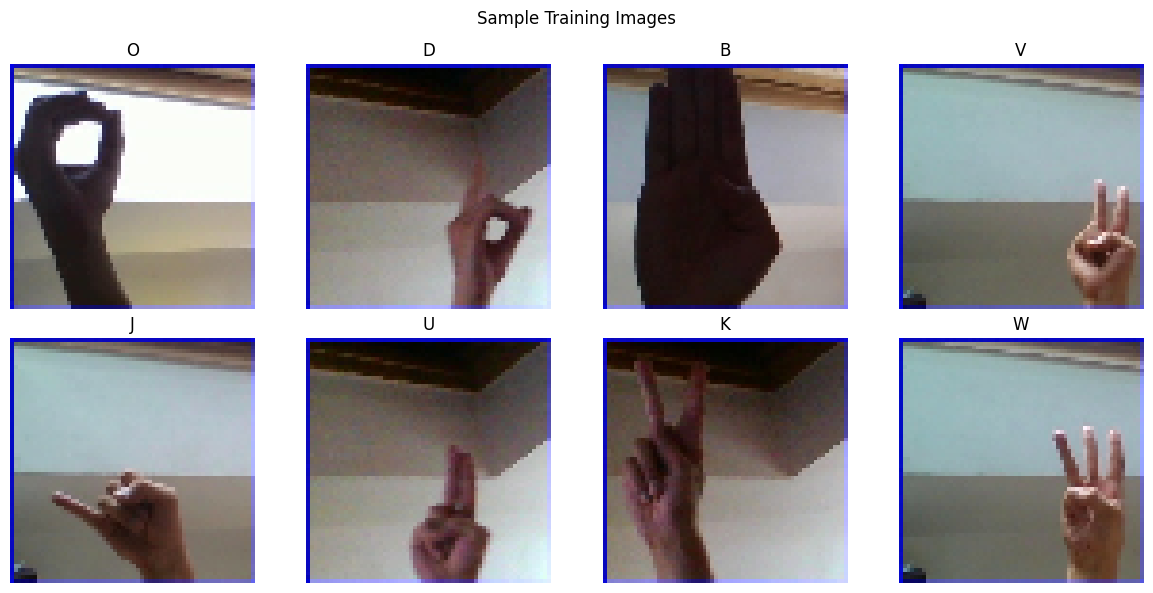

In [28]:
import matplotlib.pyplot as plt

class_names = list(train_generator.class_indices.keys())
images, labels = next(train_generator)

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i])
    label_idx = np.argmax(labels[i])
    plt.title(class_names[label_idx])
    plt.axis("off")
plt.suptitle("Sample Training Images")
plt.tight_layout()
plt.show()

## Sample Training Images

The following are sample images from the training dataset, showing hand signs for different ASL letters. This helps verify that the data is loaded correctly and well-balanced across classes.


## Training

Training the model for 10 epochs with validation monitoring.

In [9]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 80s 34ms/step - accuracy: 0.5735 - loss: 1.4629 - val_accuracy: 0.6425 - val_loss: 1.5321
Epoch 2/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 71s 32ms/step - accuracy: 0.9771 - loss: 0.0735 - val_accuracy: 0.7267 - val_loss: 1.5950
Epoch 3/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 68s 31ms/step - accuracy: 0.9891 - loss: 0.0364 - val_accuracy: 0.6863 - val_loss: 1.8559
Epoch 4/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 67s 31ms/step - accuracy: 0.9924 - loss: 0.0256 - val_accuracy: 0.7606 - val_loss: 1.5738
Epoch 5/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 66s 30ms/step - accuracy: 0.9948 - loss: 0.0188 - val_accuracy: 0.6815 - val_loss: 2.3881
Epoch 6/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 66s 30ms/step - accuracy: 0.9937 - loss: 0.0219 - val_accuracy: 0.7344 - val_loss: 1.6419
Epoch 7/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 65s 30ms/step - accuracy: 0.9967 - loss: 0.0137 - val_accuracy: 0.7462 - val_loss: 1.7898
Epoch 8/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 65s 30ms/step - accuracy: 0.9964 - loss: 0.01

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


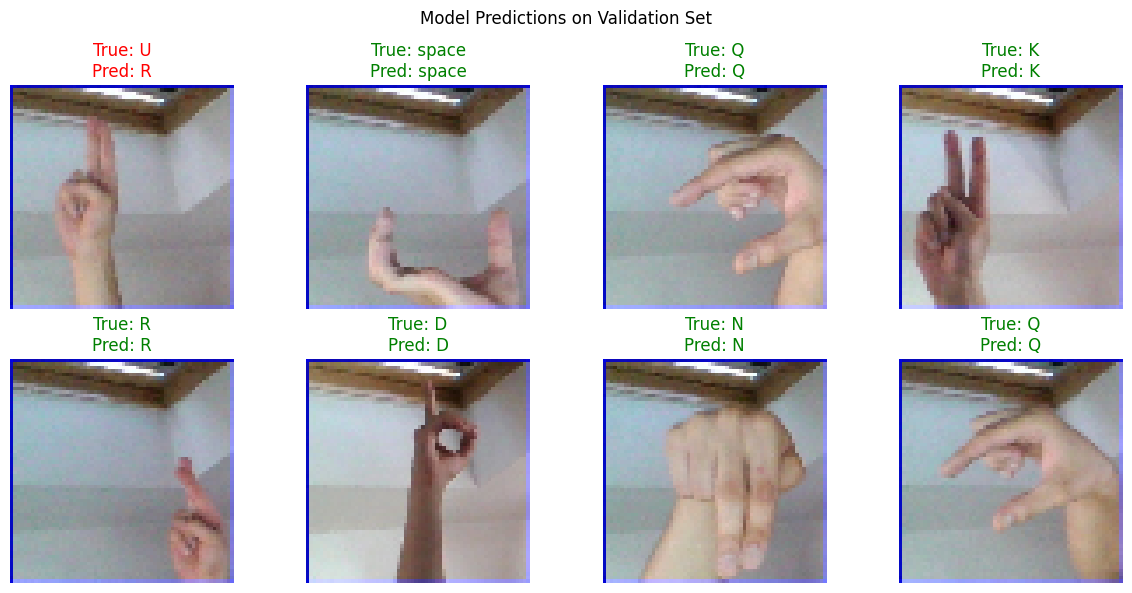

In [29]:
val_images, val_labels = next(val_generator)
preds = model.predict(val_images)
pred_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(val_labels, axis=1)

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(val_images[i])
    true_label = class_labels[true_classes[i]]
    pred_label = class_labels[pred_classes[i]]
    color = "green" if true_label == pred_label else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.axis("off")
plt.suptitle("Model Predictions on Validation Set")
plt.tight_layout()
plt.show()

## Model Predictions on Validation Images

Here are a few predictions from the trained CNN model on unseen validation images.  
Correct predictions are labeled in green; incorrect ones in red.  
This provides a visual snapshot of model performance and highlights which signs are more confusing for the model.


## Training Performance

Visualizing training and validation accuracy over epochs.

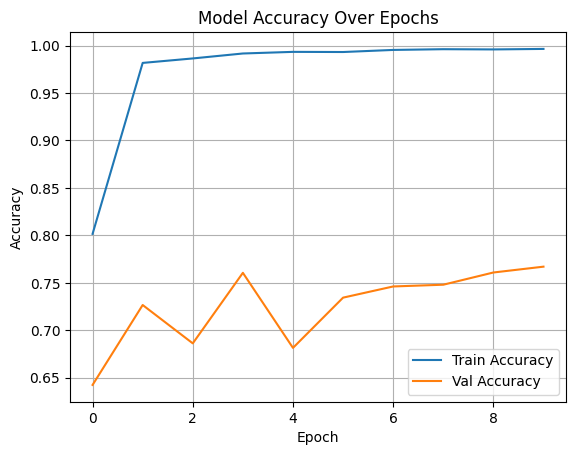

In [20]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

## Confusion Matrix

Shows which classes are being confused with others.

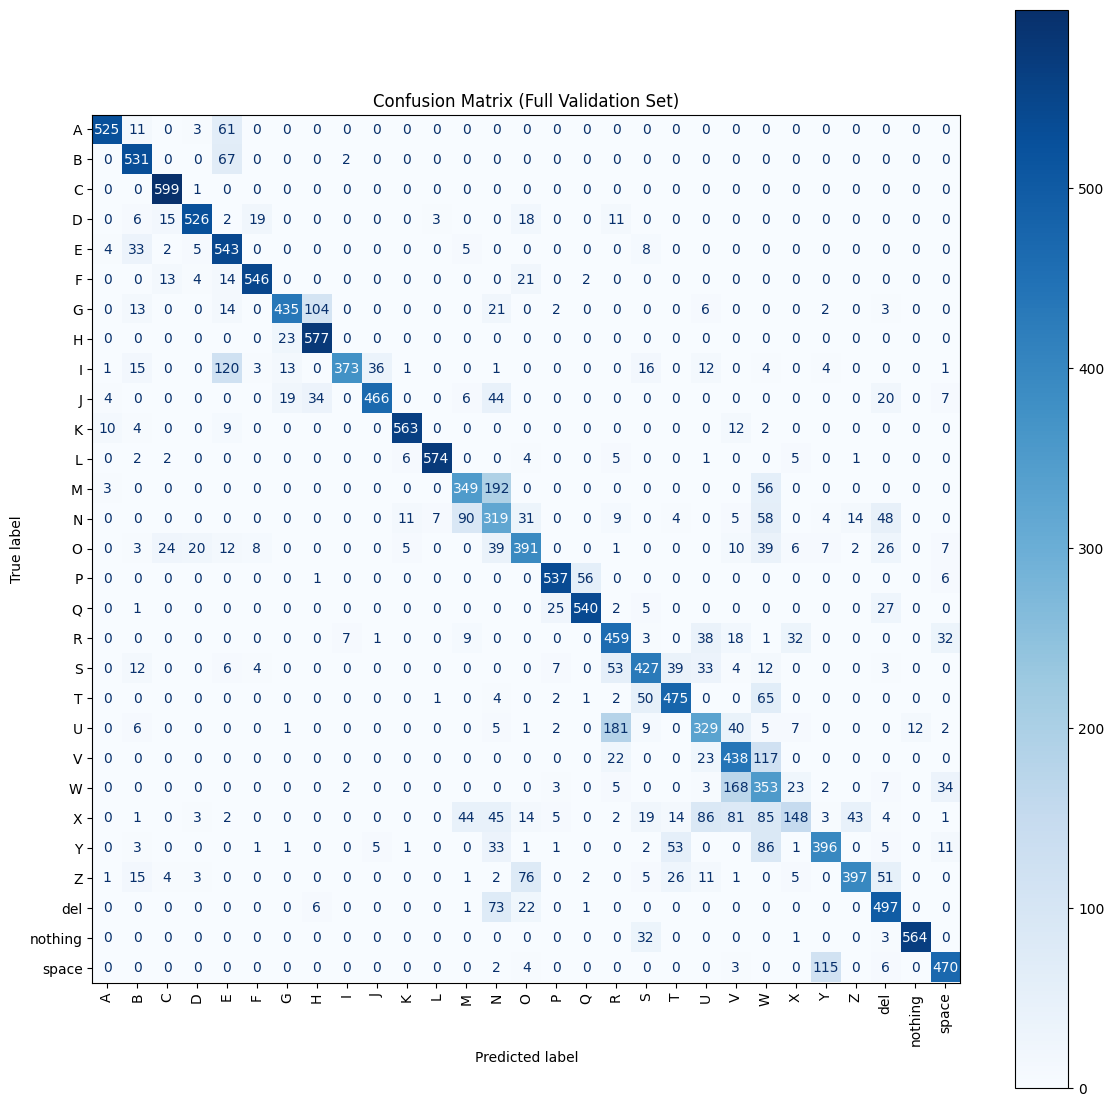

In [24]:
# Reset generator and collect all predictions
val_generator.reset()

y_true_all = []
y_pred_all = []

# Go through the full validation dataset
for i in range(len(val_generator)):
    x_batch, y_batch = val_generator[i]
    y_probs_batch = model.predict(x_batch, verbose=0)

    y_true_all.extend(np.argmax(y_batch, axis=1))
    y_pred_all.extend(np.argmax(y_probs_batch, axis=1))

# Confusion Matrix across all validation data
cm = confusion_matrix(y_true_all, y_pred_all)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

# Plot
fig, ax = plt.subplots(figsize=(14, 14))
disp.plot(cmap='Blues', xticks_rotation=90, ax=ax)
plt.title("Confusion Matrix (Full Validation Set)")
plt.grid(False)
plt.show()


In [27]:
print("Accuracy:", accuracy_score(y_true_all, y_pred_all))
print(classification_report(y_true_all, y_pred_all, target_names=class_labels))

Accuracy: 0.7670689655172414
              precision    recall  f1-score   support

           A       0.96      0.88      0.91       600
           B       0.81      0.89      0.85       600
           C       0.91      1.00      0.95       600
           D       0.93      0.88      0.90       600
           E       0.64      0.91      0.75       600
           F       0.94      0.91      0.92       600
           G       0.88      0.72      0.80       600
           H       0.80      0.96      0.87       600
           I       0.97      0.62      0.76       600
           J       0.92      0.78      0.84       600
           K       0.96      0.94      0.95       600
           L       0.98      0.96      0.97       600
           M       0.69      0.58      0.63       600
           N       0.41      0.53      0.46       600
           O       0.67      0.65      0.66       600
           P       0.92      0.90      0.91       600
           Q       0.90      0.90      0.90       60

## Conclusion

This project built and evaluated a Convolutional Neural Network (CNN) to classify ASL (American Sign Language) alphabet gestures from images across **29 classes**, including A–Z, space, delete, and nothing.

The model achieved a validation accuracy of **77%** on a balanced dataset of over 87,000 images. Performance was strong across many letters, especially those with distinct hand shapes like **C, L, and K**. However, some signs—such as **M/N, W/X, and U/V**—proved more difficult due to visual similarities.

### Key Accomplishments

- Implemented a CNN model from scratch using TensorFlow/Keras
- Achieved strong results with clean preprocessing and early augmentation
- Analyzed model behavior using confusion matrices and classification reports
- Identified challenges related to intra-class similarity in ASL gestures

### Next Steps (Future Work)

- Experiment with **pre-trained models** like MobileNetV2 or EfficientNet
- Apply **more aggressive augmentation** or **contrastive learning** to separate confusing classes
- Build a real-time demo using webcam input and OpenCV
- Expand to full ASL sentences using video and temporal modeling (e.g., RNNs or Transformers)
